In [1]:
from modules.vectorizer import BidirectionalLM
from modules.elmo_data import CustomIterableDataset, load_token_dict, make_batch as make_batch_init

from functools import partial

token_dict = load_token_dict('../../fast_data/Elmo-taiga/vocab.txt')
make_batch = partial(make_batch_init, token_dict=token_dict)

In [2]:
import pytorch_lightning as pl
import torch

In [3]:
model_params = {
    'num_layers': 2, 
    'hidden_size': 2048,
    'sru_attn_proj_size': 1024,
    'attention_last_n_layers': 0
}

vectorizer = BidirectionalLM(
    vocab_size=len(token_dict), 
    model_params=model_params, 
    learning_rate=0.001, 
    cutoffs=[10_000, 50_000],
    elmo_options_file='../Elmo-taiga/options.json', 
    elmo_weight_file='../Elmo-taiga/model.hdf5',
)

for param in vectorizer.parameters():
    param.requires_grad = True
    torch.nn.init.normal_(param, std=1e-10)    
    param.requires_grad = True

Следующий шаг: конструируем загрузку данных

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

dataset = CustomIterableDataset('joined_news_long_texts_udpipe_8796201_293713268.txt')
train_dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=24, pin_memory=True, 
    collate_fn=make_batch
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="elmo_lstm_2lrs_checkpoints", save_top_k=-1)
torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(
    gradient_clip_val=1.5, 
    max_epochs=1, 
    callbacks=[
        pl.callbacks.TQDMProgressBar(refresh_rate=100), 
        checkpoint_callback
    ],
    limit_train_batches=549763 // 60
    # limit_train_batches=1
    # precision=16   
)
            
vectorizer.fit(vectorizer, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/fast_data/anaconda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /media/fast_data/ELMO-SRU/elmo_lstm_2lrs_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                       | Params
-------------------------------------------------------------
0 | bilstm        | _ElmoBiLm                  | 129 M 
1 | forward_loss  | AdaptiveLogSoftmaxWithLoss | 16.7 M
2 | backward_loss | AdaptiveLogSoftmaxWithLoss | 16.7 M
-------------------------------------------------------------
162 M     Trainable params
0         Non-trainable params
162 M     Total params
650.798   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [5]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline 

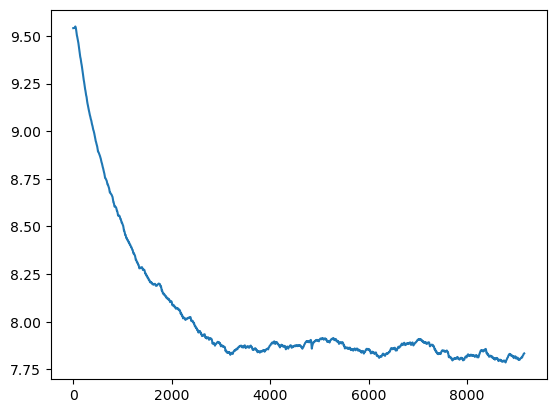

In [6]:
# h = np.array(model.history[1000:])
h = np.array(vectorizer.history)
eps = 0.001
hh = [h[0]]
for v in h[1:]:
    hh.append(hh[-1] * (1-eps) + v * eps)
    
plt.plot(hh)

* * * 
# NER Test

In [7]:
from modules.ner_tasks import RUSSIAN
from modules.ner_data import get_dataloaders

ner_task = RUSSIAN['WikiNeural']

In [8]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    ner_task,
    batch_size=128,
    num_workers=24,
    pin_memory=True
)

In [11]:
vectorizer.freeze()

In [17]:
%load_ext autoreload
%autoreload 2

In [20]:
import importlib
importlib.reload(CRFModel)

ImportError: module CRFModel not in sys.modules

In [18]:
from modules.crf_model import CRFModel

vectorizer.emb_size=1024

ner_model = CRFModel(
    ner_labels=ner_task['labels_vocab'], 
    vectorizer=vectorizer, 
    weight_decay=0, 
    learning_rate=1e-3
)

trainer = pl.Trainer(
    accelerator='gpu', 
    gradient_clip_val=10.5, 
    max_epochs=5, 
)

trainer.fit(ner_model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | vectorizer | BidirectionalLM | 162 M 
1 | lstm       | LSTM            | 1.4 M 
2 | relu       | ReLU            | 0     
3 | line       | Linear          | 2.2 K 
4 | crf        | CRF             | 99    
-----------------------------------------------
1.4 M     Trainable params
162 M     Non-trainable params
164 M     Total params
656.598   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

AttributeError: 'tuple' object has no attribute 'dim'

In [ ]:
trainer.validate(ner_model, test_dataloader)